In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import h3
from geopy.distance import geodesic

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

from matplotlib.ticker import MultipleLocator

## ToDo-Liste

- [ ] Verhältnis total miles und total price
  - [ ] Ausreißer rausschmeißen? Randfälle sind bei 100 000 schon 15 000
  - [ ] Möglichkeit Distanz und Zeit künstlich hinzufügen durch (Durchschnitt, Distanzberechnung) evaluieren
- [ ] Weitere Features hinzufügen
  - [ ] Distance to city centre
  - [ ] Fahrt zum Sportevent oder Fahrt zum Cafe
  - [ ] Distance to next café, POI point
- [ ] Welche spatial Information? Census-Tract Koordinaten, Community Area Daten, Centroid Daten und H3 mit Res 4, 6, 8
  - [ ] Census-Tract Koordinaten
  - [ ] Community Area Daten
  - [ ] Centroid Daten
  - [ ] H3 mit Res 4, 6, 8

## Data Loading, Checking, further Data Preparation and Cleaning

In [2]:
data = pd.read_csv("../data/analytics_trip_data.csv")

In [3]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
# Korrekte Verwendung der describe-Methode
data.describe()

# Überprüfe auf NaN-Werte jeder Spalte
nan_info = data.isna().sum()
print(nan_info)

trip_id                          0
taxi_id                          9
trip_start_timestamp             0
trip_end_timestamp               0
trip_seconds                    22
trip_miles                      12
pickup_census_tract          53342
dropoff_census_tract         53342
pickup_community_area           53
dropoff_community_area         830
fare                            19
tips                            19
tolls                        41959
extras                          19
trip_total                      19
payment_type                     0
company                          0
pickup_centroid_location         0
dropoff_centroid_location        0
h3_res_4_pickup                  0
h3_res_4_dropoff                 0
h3_res_6_pickup                  0
h3_res_6_dropoff                 0
h3_res_8_pickup                  0
h3_res_8_dropoff                 0
date                             0
temperature                      0
precipitation                    0
Game_End            

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217461 entries, 0 to 217460
Data columns (total 33 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   trip_id                    217461 non-null  object 
 1   taxi_id                    217452 non-null  object 
 2   trip_start_timestamp       217461 non-null  object 
 3   trip_end_timestamp         217461 non-null  object 
 4   trip_seconds               217439 non-null  float64
 5   trip_miles                 217449 non-null  float64
 6   pickup_census_tract        164119 non-null  float64
 7   dropoff_census_tract       164119 non-null  float64
 8   pickup_community_area      217408 non-null  float64
 9   dropoff_community_area     216631 non-null  float64
 10  fare                       217442 non-null  float64
 11  tips                       217442 non-null  float64
 12  tolls                      175502 non-null  float64
 13  extras                     21

In [5]:
data.head(1)

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_centroid_location,dropoff_centroid_location,h3_res_4_pickup,h3_res_4_dropoff,h3_res_6_pickup,h3_res_6_dropoff,h3_res_8_pickup,h3_res_8_dropoff,date,temperature,precipitation,Game_End,sports_event,poi_h3_res_8,poi_h3_res_6,poi_h3_res_4
0,431a17aafe54877bf8effca97998bc93c0a804de,e58217aab55360fd47c24c931ec25c7ab0cf7bd3917c8b98b9b1f851051a0b065f0cd8380970f70bf1b09d5453b4b2d42f81b990ac3687940ccb5a4e2fe0a216,2018-01-01 00:15:00,2018-01-01 00:30:00,945.0,3.6,1.703124e+10,1.703108e+10,24.0,8.0,13.5,2.8,0.0,0.0,16.8,Credit Card,Taxi Affiliation Service Yellow,POINT (-87.6753116216 41.906025969),POINT (-87.6288741572 41.8920726347),842664dffffffff,842664dffffffff,862664cafffffff,862664c1fffffff,882664cac1fffff,882664c1e1fffff,2018-01-01 01:53:00,-18.333333,0.0,2018-01-01 00:00:00,0.0,66.0,563.0,3458


In [6]:
#Hier erstmal date genommen, vielleicht doch lieber startzeit?
data['date_column'] = pd.to_datetime(data['date'])
data['hour']= data["date_column"].dt.hour
data['weekday']=data["date_column"].dt.weekday
data["month"]=data["date_column"].dt.month

data = data[(data['trip_seconds'] != 0) & (data['trip_miles'] != 0) & (data['fare'] != 0)]

data['price_per_mile'] = data['trip_total'] / data['trip_miles']

In [7]:
# Koordinaten des Stadtzentrums von Chicago
#chicago_coords = (41.8781, -87.6298)
#chicago_h3 = h3.geo_to_h3(chicago_coords[0], chicago_coords[1], 8)
#data['distance_to_chicago'] = data['h3_res_8'].apply(lambda h3_index: h3.h3_distance(chicago_h3, h3_index))

In [8]:
# Koordinaten des Stadtzentrums von Chicago
chicago_coords = (41.8781, -87.6298)

# Funktion zum Extrahieren der Koordinaten aus dem WKT-Format
def extract_coords(point):
    point = point.replace('POINT (', '').replace(')', '')
    lon, lat = map(float, point.split())
    return lat, lon

# Funktion zur Berechnung der Distanz
def calculate_distance_to_chicago(point):
    point_coords = extract_coords(point)
    return geodesic(point_coords, chicago_coords).miles

# Berechnen der Distanz zu Chicago und Hinzufügen einer neuen Spalte
data['distance_to_chicago'] = data['pickup_centroid_location'].apply(calculate_distance_to_chicago)

# Berechnen der Distanz zu Chicago und Hinzufügen einer neuen Spalte
data['distance_from_chicago'] = data['dropoff_centroid_location'].apply(calculate_distance_to_chicago)


## Feature Creating & Selection

In [9]:
features = ["trip_seconds", "price_per_mile", "trip_miles", "fare", "hour", "weekday", "month","temperature", "distance_to_chicago", "distance_from_chicago"]

In [10]:
Cluster_all = data[features]

In [11]:
Cluster_all.describe()

,trip_seconds,price_per_mile,trip_miles,fare,hour,weekday,month,temperature,distance_to_chicago,distance_from_chicago
count,191185.000000,191184.000000,191187.000000,191184.000000,191199.000000,191199.000000,191199.000000,191199.000000,191199.000000,191199.000000
mean,867.388733,10.773280,3.802252,13.663982,13.593199,2.847787,6.351231,12.037705,2.795882,2.651628
std,1164.422676,127.739126,5.299028,14.323286,5.637112,1.876186,3.344402,11.801675,4.230729,3.491866
min,1.000000,0.000244,0.010000,0.010000,0.000000,0.000000,1.000000,-22.777778,0.243471,0.243471
25%,360.000000,4.043529,0.900000,6.250000,10.000000,1.000000,4.000000,2.222222,0.657472,0.667513
50%,600.000000,6.041667,1.500000,8.250000,14.000000,3.000000,6.000000,10.555556,1.049266,1.404790
75%,991.000000,8.695652,3.600000,14.000000,18.000000,4.000000,9.000000,22.777778,2.012669,2.882279
max,81791.000000,43563.400000,173.700000,3000.820000,23.000000,6.000000,12.000000,35.555556,16.238510,16.551312


In [12]:
print("Vor dem Entfernen der Ausreißer:")
Cluster_all.describe()

Vor dem Entfernen der Ausreißer:


,trip_seconds,price_per_mile,trip_miles,fare,hour,weekday,month,temperature,distance_to_chicago,distance_from_chicago
count,191185.000000,191184.000000,191187.000000,191184.000000,191199.000000,191199.000000,191199.000000,191199.000000,191199.000000,191199.000000
mean,867.388733,10.773280,3.802252,13.663982,13.593199,2.847787,6.351231,12.037705,2.795882,2.651628
std,1164.422676,127.739126,5.299028,14.323286,5.637112,1.876186,3.344402,11.801675,4.230729,3.491866
min,1.000000,0.000244,0.010000,0.010000,0.000000,0.000000,1.000000,-22.777778,0.243471,0.243471
25%,360.000000,4.043529,0.900000,6.250000,10.000000,1.000000,4.000000,2.222222,0.657472,0.667513
50%,600.000000,6.041667,1.500000,8.250000,14.000000,3.000000,6.000000,10.555556,1.049266,1.404790
75%,991.000000,8.695652,3.600000,14.000000,18.000000,4.000000,9.000000,22.777778,2.012669,2.882279
max,81791.000000,43563.400000,173.700000,3000.820000,23.000000,6.000000,12.000000,35.555556,16.238510,16.551312


In [13]:
# Liste der spezifischen Features
selected_features = ['price_per_mile', 'trip_seconds', 'trip_miles', 'fare', 'temperature', 'distance_to_chicago', 'distance_from_chicago']

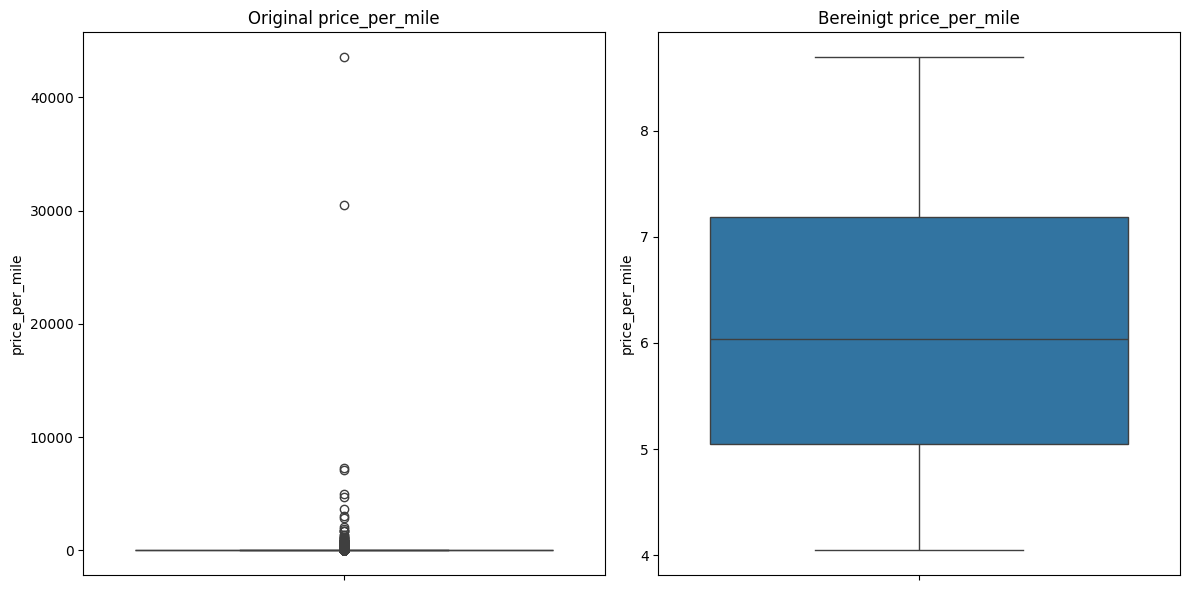

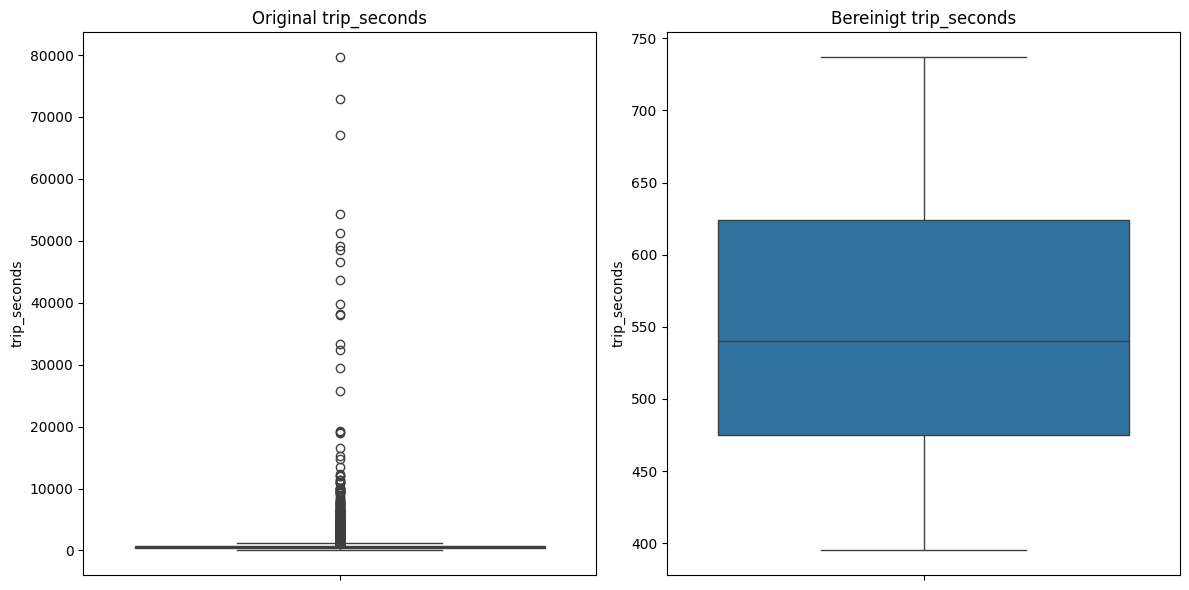

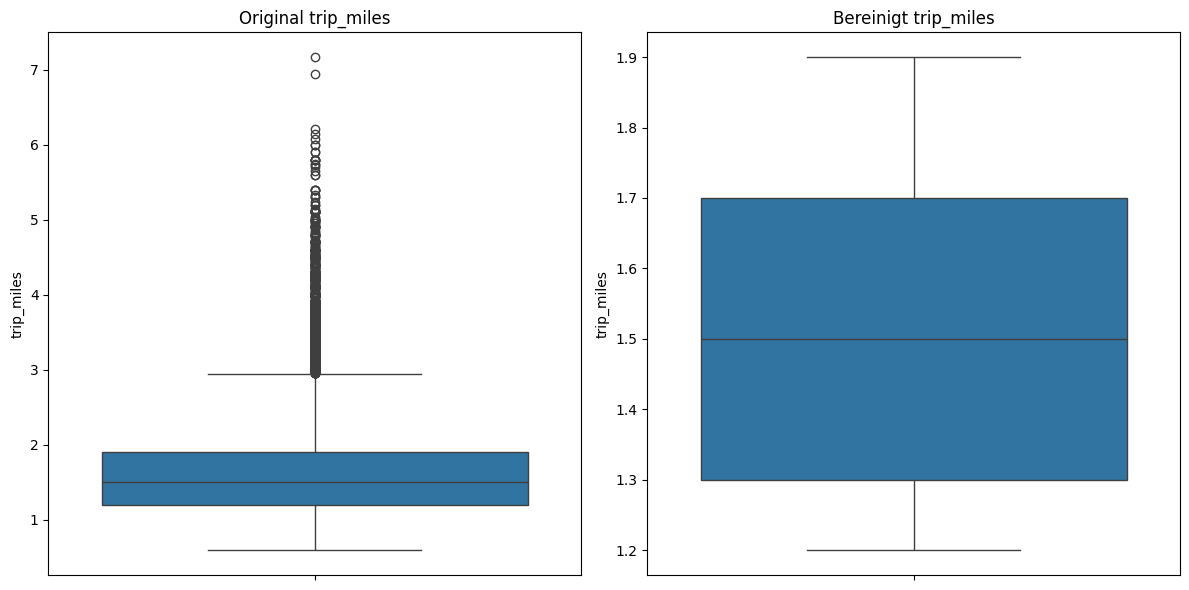

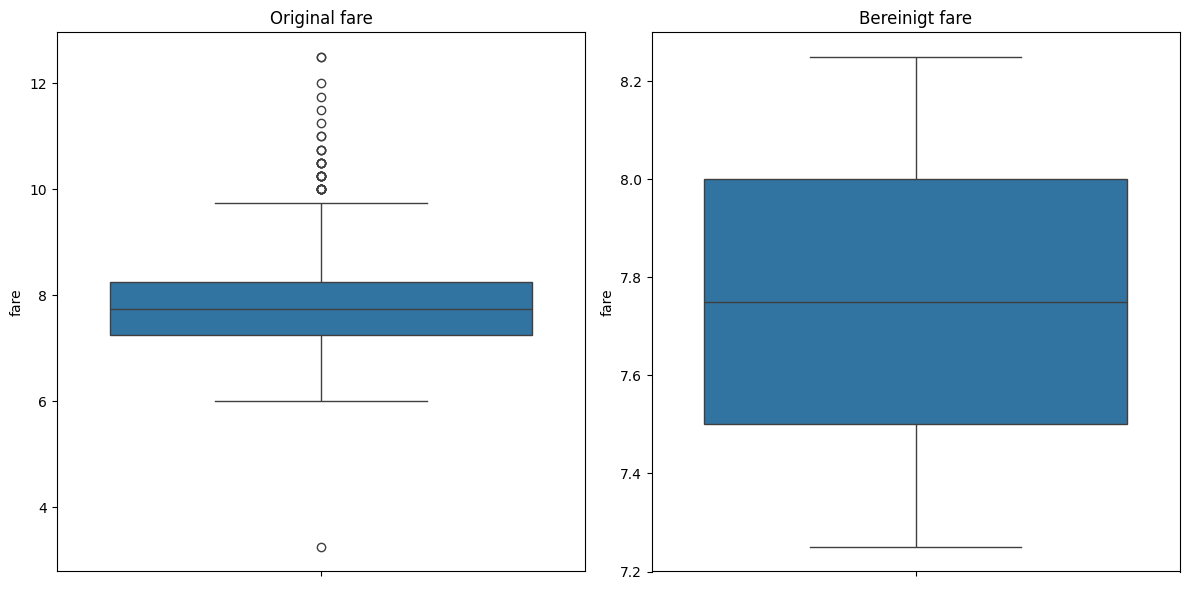

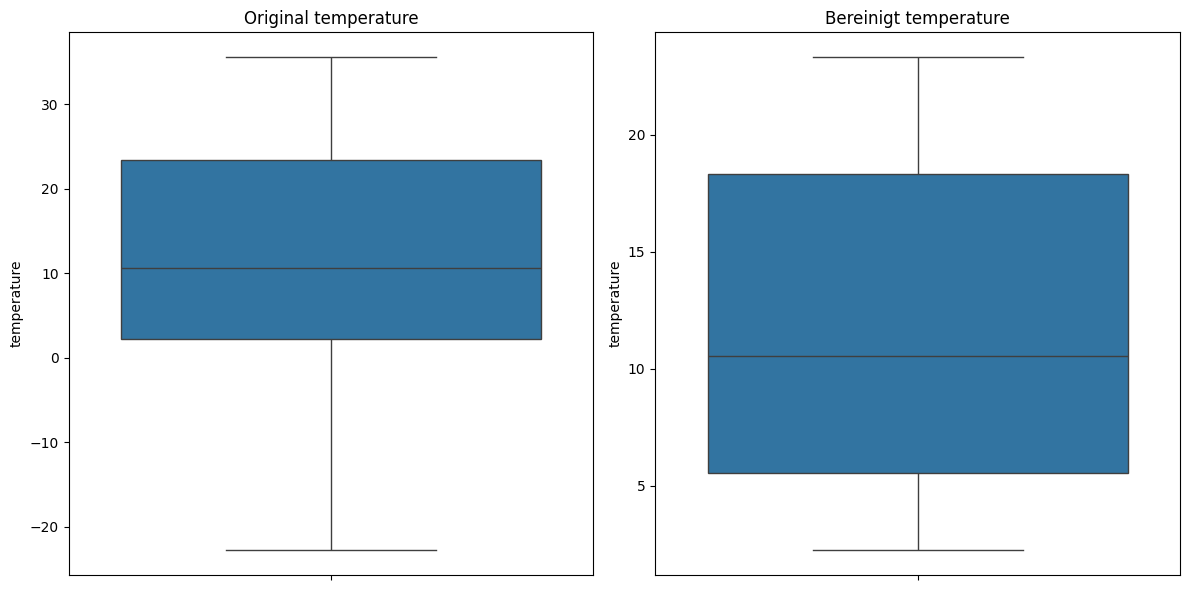

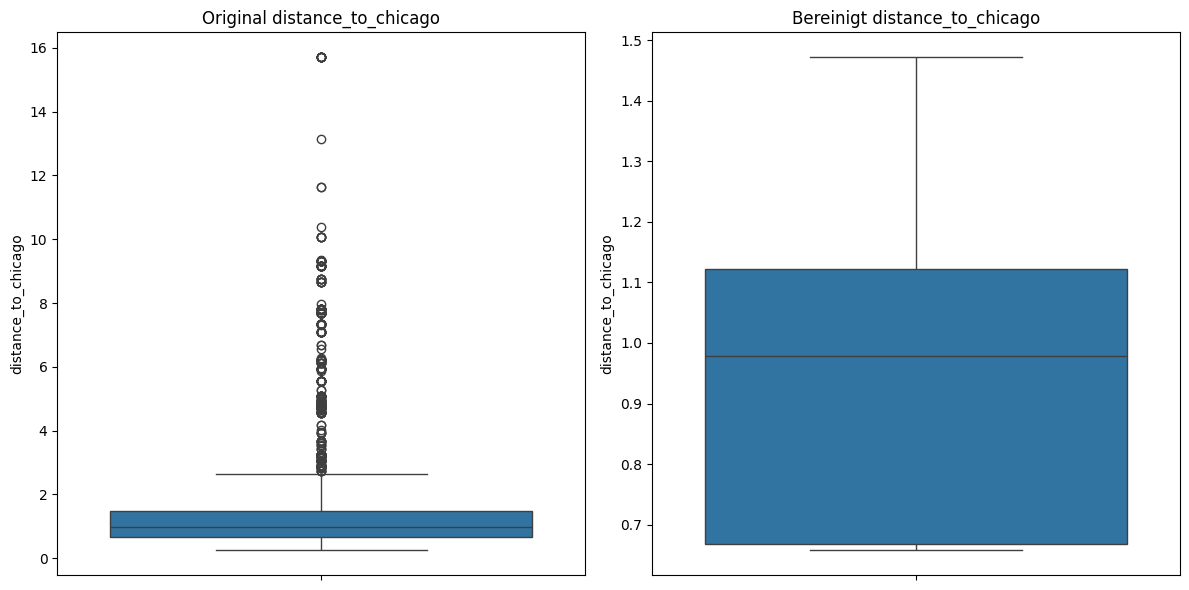

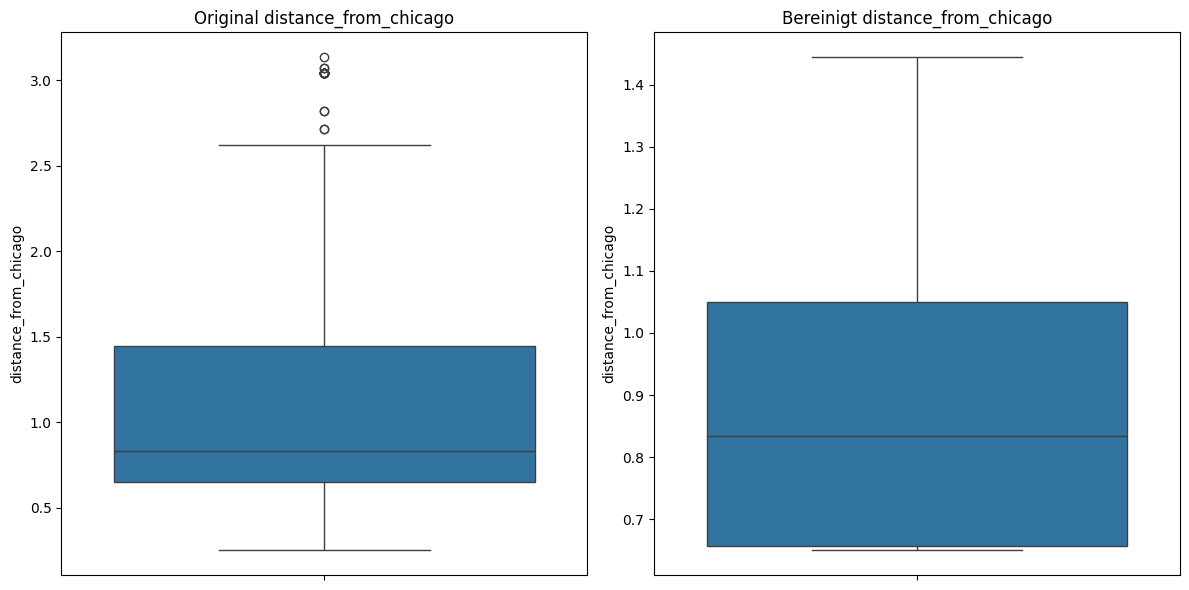

In [14]:
# TODO: Werte ändern bei lower und upper bound
def remove_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    # Both values should be 1.5 instead of 0
    lower_bound = Q1 - 0 * IQR
    upper_bound = Q3 + 0 * IQR
    df_cleaned = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    return df_cleaned


for feature in selected_features:
    # Originaler Boxplot
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    sns.boxplot(y=Cluster_all[feature])
    plt.title(f'Original {feature}')
    
    # Entferne Ausreißer
    Cluster_all = remove_outliers(Cluster_all, feature)
    
    # Boxplot nach Bereinigung
    plt.subplot(1, 2, 2)
    sns.boxplot(y=Cluster_all[feature])
    plt.title(f'Bereinigt {feature}')
    
    plt.tight_layout()
    plt.show()

In [15]:
print("\nNach dem Entfernen der Ausreißer:")
Cluster_all.describe()


Nach dem Entfernen der Ausreißer:


,trip_seconds,price_per_mile,trip_miles,fare,hour,weekday,month,temperature,distance_to_chicago,distance_from_chicago
count,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000
mean,542.589187,6.367619,1.451728,7.736010,13.625099,2.797948,6.459747,11.810269,0.937809,0.881934
std,76.534141,1.044674,0.171185,0.341704,5.035439,1.820893,3.303170,6.795140,0.281563,0.237776
min,396.000000,4.078947,1.200000,7.250000,0.000000,0.000000,1.000000,2.222222,0.657472,0.649758
25%,480.000000,5.574628,1.300000,7.500000,10.000000,1.000000,4.000000,5.555556,0.667513,0.657472
50%,540.000000,6.250000,1.410000,7.750000,14.000000,3.000000,6.000000,10.555556,0.965522,0.834910
75%,600.000000,7.163537,1.600000,8.000000,18.000000,4.000000,10.000000,18.333333,1.049266,1.049266
max,735.000000,8.695652,1.900000,8.250000,23.000000,6.000000,12.000000,23.333333,1.472050,1.444502


In [16]:
#Cluster_all_ohe = pd.get_dummies(Cluster_all, columns=["hour", "weekday", "month"])
def one_hot_encoding(df, list):
    for element in list:
        one_hot_encoded = pd.get_dummies(df[element], prefix=element)

        one_hot_encoded = one_hot_encoded.astype(int)
        
        # Concatenate the one-hot encoded features with the original DataFrame
        df = pd.concat([df, one_hot_encoded], axis=1)

        # Drop the original column after one-hot encoding
        df = df.drop(columns=[element])
    return  df

Cluster_all_ohe = one_hot_encoding(Cluster_all, ["hour", "weekday", "month"])


In [17]:
Cluster_all_ohe.head(1)

,trip_seconds,price_per_mile,trip_miles,fare,temperature,distance_to_chicago,distance_from_chicago,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
4192,555.0,8.267717,1.27,7.5,3.333333,1.279285,1.122737,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [18]:
print(Cluster_all_ohe.columns)

Index(['trip_seconds', 'price_per_mile', 'trip_miles', 'fare', 'temperature',
       'distance_to_chicago', 'distance_from_chicago', 'hour_0', 'hour_1',
       'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8',
       'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14',
       'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20',
       'hour_21', 'hour_22', 'hour_23', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12'],
      dtype='object')


## Data Normalisation/Scaling

In [19]:
columns_to_normalize=["trip_seconds", "trip_miles","price_per_mile", "fare", "temperature","distance_to_chicago", "distance_from_chicago"]
#columns_to_normalize=['connectionDuration', 'chargingDuration', 'kWhDelivered', 'kWhRequested', 'precipitation', 'temperature', 'minutesAvailable']

In [20]:
scaler = MinMaxScaler()
Cluster_all_ohe[columns_to_normalize] = scaler.fit_transform(Cluster_all_ohe[columns_to_normalize])
print(Cluster_all_ohe.columns)

Index(['trip_seconds', 'price_per_mile', 'trip_miles', 'fare', 'temperature',
       'distance_to_chicago', 'distance_from_chicago', 'hour_0', 'hour_1',
       'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8',
       'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14',
       'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20',
       'hour_21', 'hour_22', 'hour_23', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12'],
      dtype='object')


In [21]:
Cluster_all_ohe.describe()

,trip_seconds,price_per_mile,trip_miles,fare,temperature,distance_to_chicago,distance_from_chicago,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
count,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.00000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000
mean,0.432416,0.495737,0.359612,0.486010,0.454171,0.344150,0.292140,0.014207,0.005919,0.003946,0.001579,0.000789,0.004341,0.029992,0.065904,0.054459,0.052092,0.054459,0.067088,0.063141,0.051697,0.069850,0.068666,0.073796,0.065114,0.065509,0.052881,0.048934,0.036701,0.030781,0.018153,0.132991,0.153118,0.157064,0.174822,0.189818,0.106156,0.086030,0.05367,0.059195,0.114838,0.143252,0.095107,0.074586,0.046961,0.037096,0.102605,0.153512,0.067088,0.052092
std,0.225764,0.226281,0.244550,0.341704,0.321875,0.345655,0.299185,0.118366,0.076725,0.062708,0.039707,0.028088,0.065756,0.170599,0.248163,0.226967,0.222256,0.226967,0.250223,0.243265,0.221458,0.254944,0.252935,0.261491,0.246776,0.247471,0.223840,0.215774,0.188063,0.172759,0.133531,0.339632,0.360172,0.363933,0.379890,0.392235,0.308098,0.280464,0.22541,0.236036,0.318890,0.350399,0.293420,0.262773,0.211598,0.189033,0.303502,0.360552,0.250223,0.222256
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.247788,0.323971,0.142857,0.250000,0.157895,0.012326,0.009706,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.424779,0.470260,0.300000,0.500000,0.394737,0.378171,0.232970,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.601770,0.668137,0.571429,0.750000,0.763158,0.480977,0.502687,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000

## PCA

(2534, 50)
the total variancein our dataset is 3.2850297748879487
the 95% of the variance in our dataset is 3.120778286143551


Text(0, 0.5, '% explained_variance_ratio')

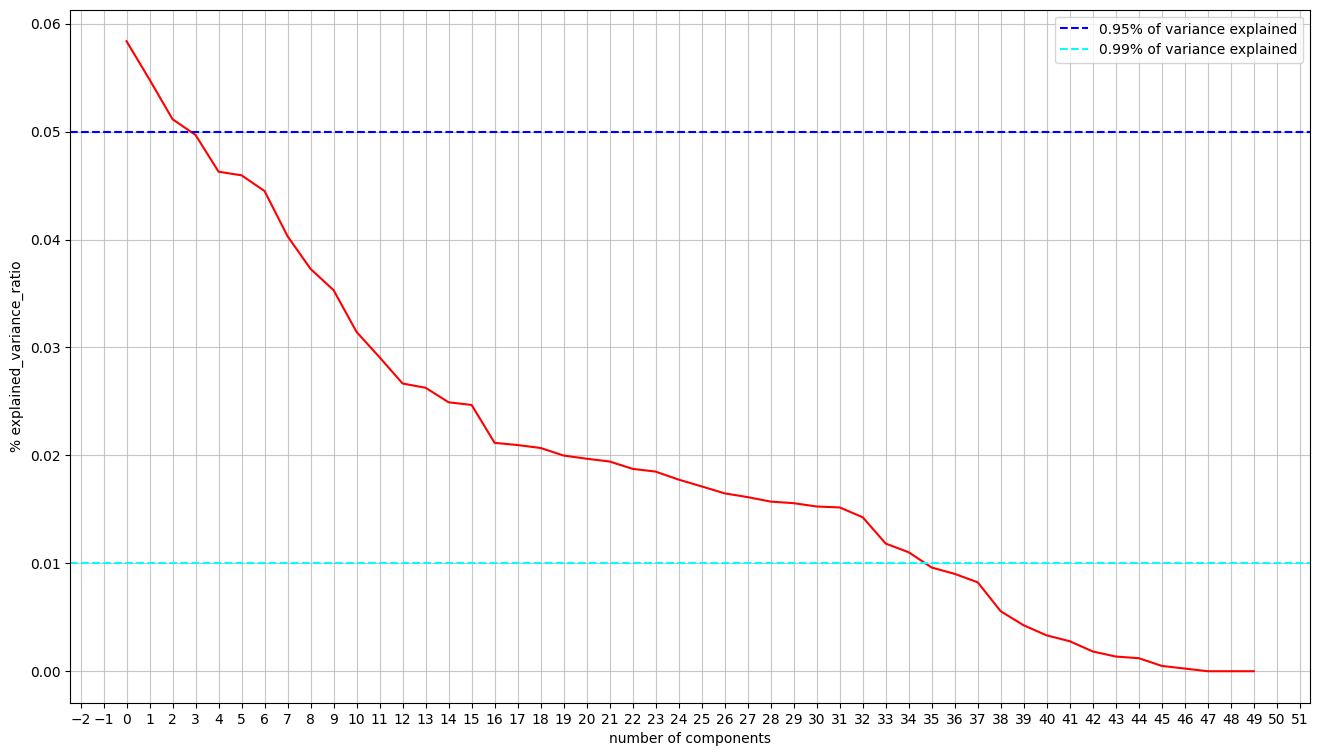

In [22]:
number_comp= Cluster_all_ohe.shape[1]
print(Cluster_all_ohe.shape)
pca= PCA(n_components=number_comp, random_state=47)
X_pca = pca.fit(Cluster_all_ohe).transform(Cluster_all_ohe)

total_variance =sum(pca.explained_variance_)
variance95= total_variance * 0.95
print(f"the total variancein our dataset is {total_variance}")
print(f"the 95% of the variance in our dataset is {variance95}")

a=zip(range(0,number_comp), pca.explained_variance_)
a= pd.DataFrame(a, columns=["PCA Comp", "Explained Variance"])

plt.figure(1, figsize=(16,9))
plt.plot(pca.explained_variance_ratio_, c="r")
tick_step = 1
plt.gca().xaxis.set_major_locator(MultipleLocator(tick_step))
plt.axhline(y=0.05, color='blue', linestyle='--', label='0.95% of variance explained')
plt.axhline(y=0.01, color='cyan', linestyle='--', label='0.99% of variance explained')
plt.grid(True, alpha=0.7)
plt.legend()
plt.xlabel("number of components")
plt.ylabel("% explained_variance_ratio")

## Finding Number of Clusters

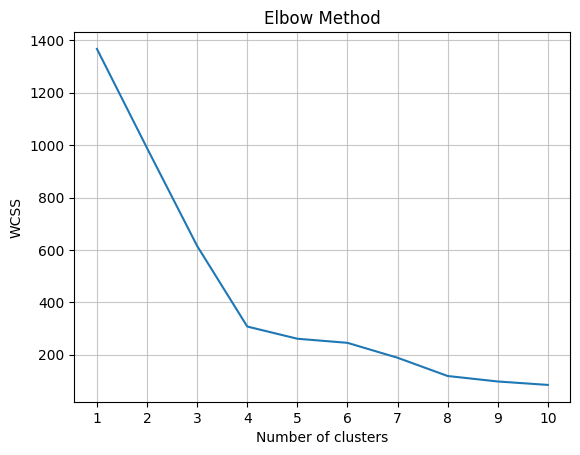

In [23]:
pca= PCA(n_components=3, random_state=47)
X_pca = pca.fit(Cluster_all_ohe).transform(Cluster_all_ohe)

wcss = []  # Within-Cluster-Sum-of-Squares

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

# Plot the Elbow graph
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
tick_step = 1
plt.gca().xaxis.set_major_locator(MultipleLocator(tick_step))
plt.grid(True, alpha=0.7)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  # Within-Cluster-Sum-of-Squares
plt.show()

## Clustering (Hard)

In [24]:
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=47)
kmeans.fit(X_pca)

KMeans(n_clusters=5, random_state=47)

In [25]:
labels = kmeans.labels_

# Calculate the silhouette score for c_raw2
silhouette_score = silhouette_score(X_pca, labels)
print(f"Silhouette Score for 4 clusters: {silhouette_score}")

Silhouette Score for 4 clusters: 0.5662099065774565


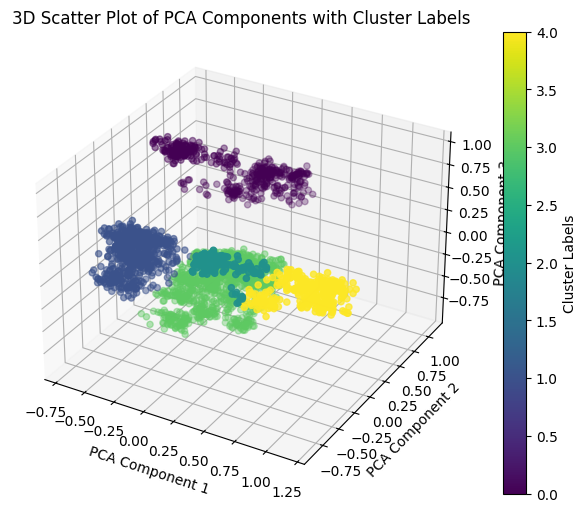

In [26]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color-coded clusters
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels, cmap='viridis')

# Add labels and title
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title('3D Scatter Plot of PCA Components with Cluster Labels')

# Add colorbar for cluster labels
colorbar = plt.colorbar(scatter)
colorbar.set_label('Cluster Labels')

# Display the plot
plt.show()

In [27]:
Cluster_all_knn = Cluster_all.copy()
Cluster_all_knn["clusters"]= labels

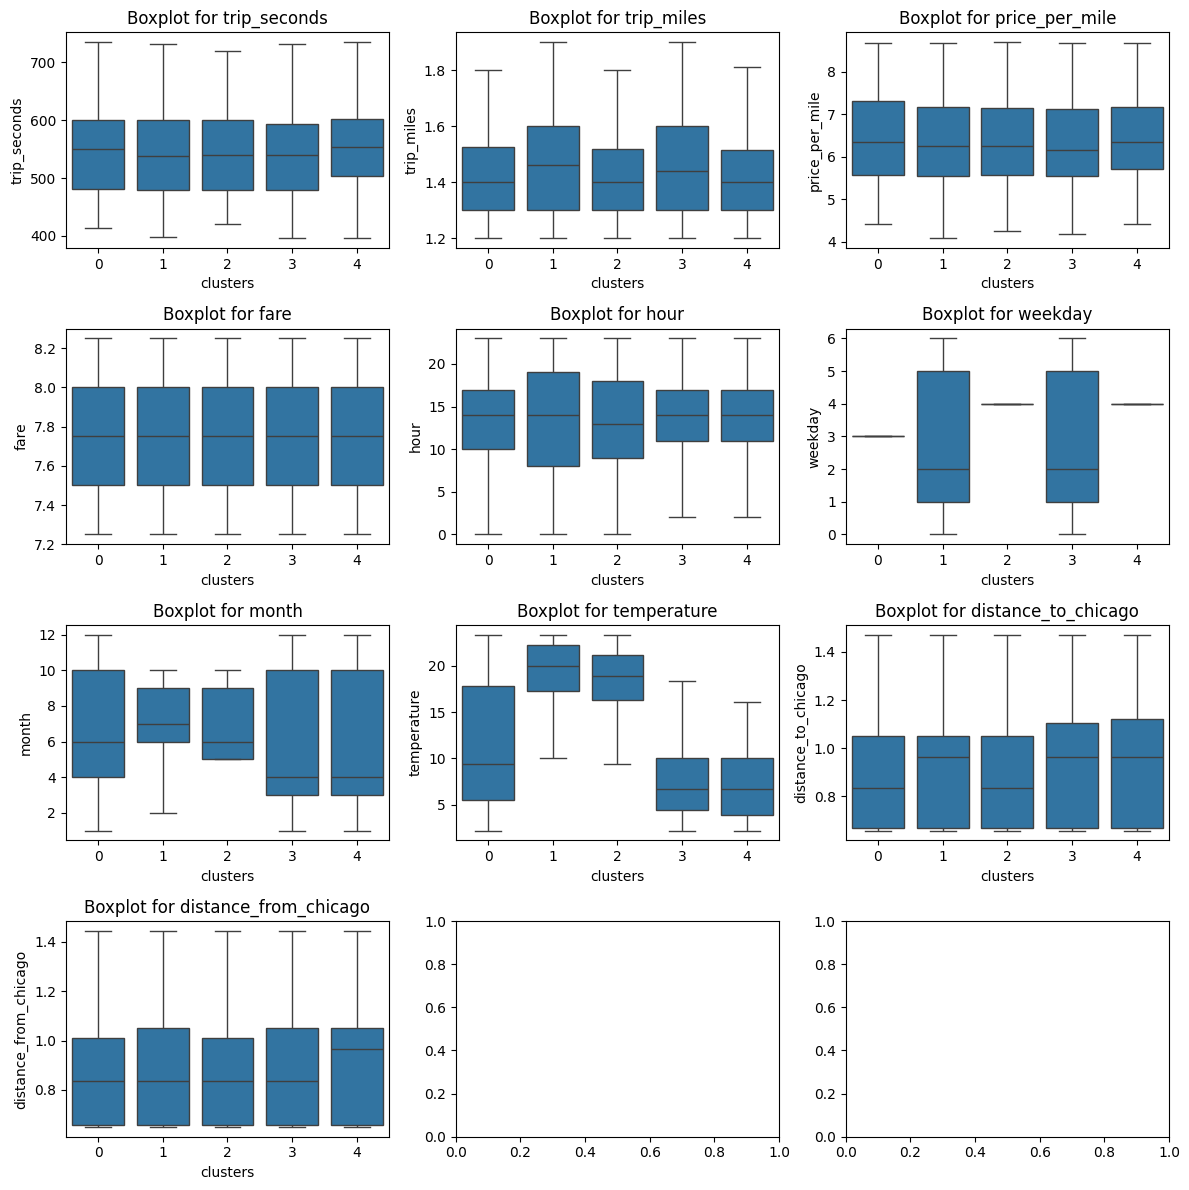

In [28]:
features = ["trip_seconds", "trip_miles", "price_per_mile", "fare", "hour", "weekday", "month","temperature", "distance_to_chicago", "distance_from_chicago"]

# Create a 3x3 subplot grid
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 12))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate through features and create boxplots
for i, feature in enumerate(features):
    
    sns.boxplot(x='clusters', y=feature, data=Cluster_all_knn, ax=axes[i], showfliers=False)
    
    # Set subplot title
    axes[i].set_title(f'Boxplot for {feature}')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

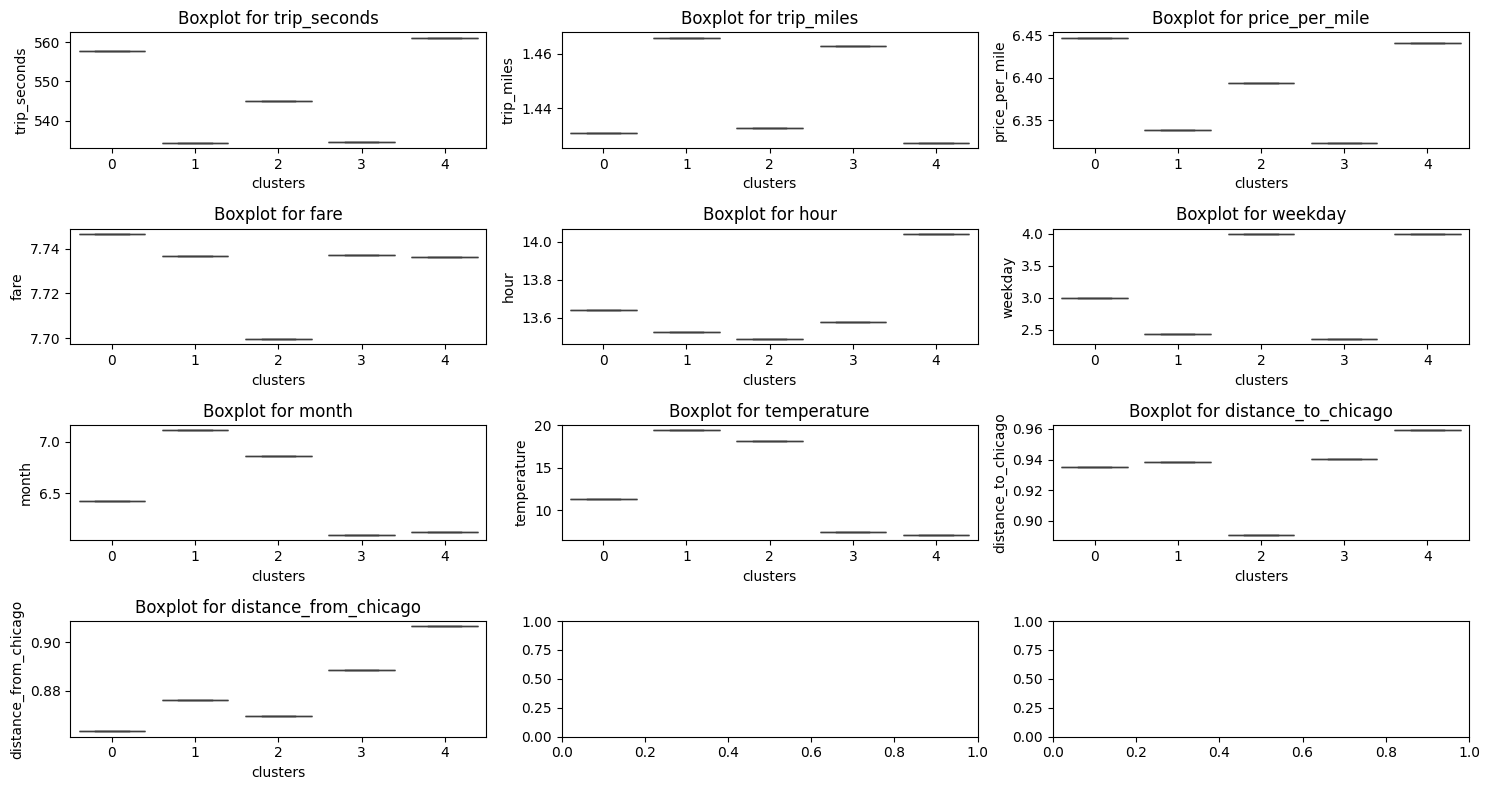

In [29]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate through features and create boxplots
for i, feature in enumerate(features):
    df = Cluster_all_knn[[feature, 'clusters']].groupby('clusters', as_index=False).mean()
    
    # Plot boxplot in the i-th subplot
    sns.boxplot(x='clusters', y=df.columns[1], data=df, ax=axes[i])
    
    # Set subplot title
    axes[i].set_title(f'Boxplot for {df.columns[1]}')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

In [30]:
Cluster_all_knn[columns_to_normalize] = scaler.fit_transform(Cluster_all_knn[columns_to_normalize])

<Figure size 1600x900 with 0 Axes>

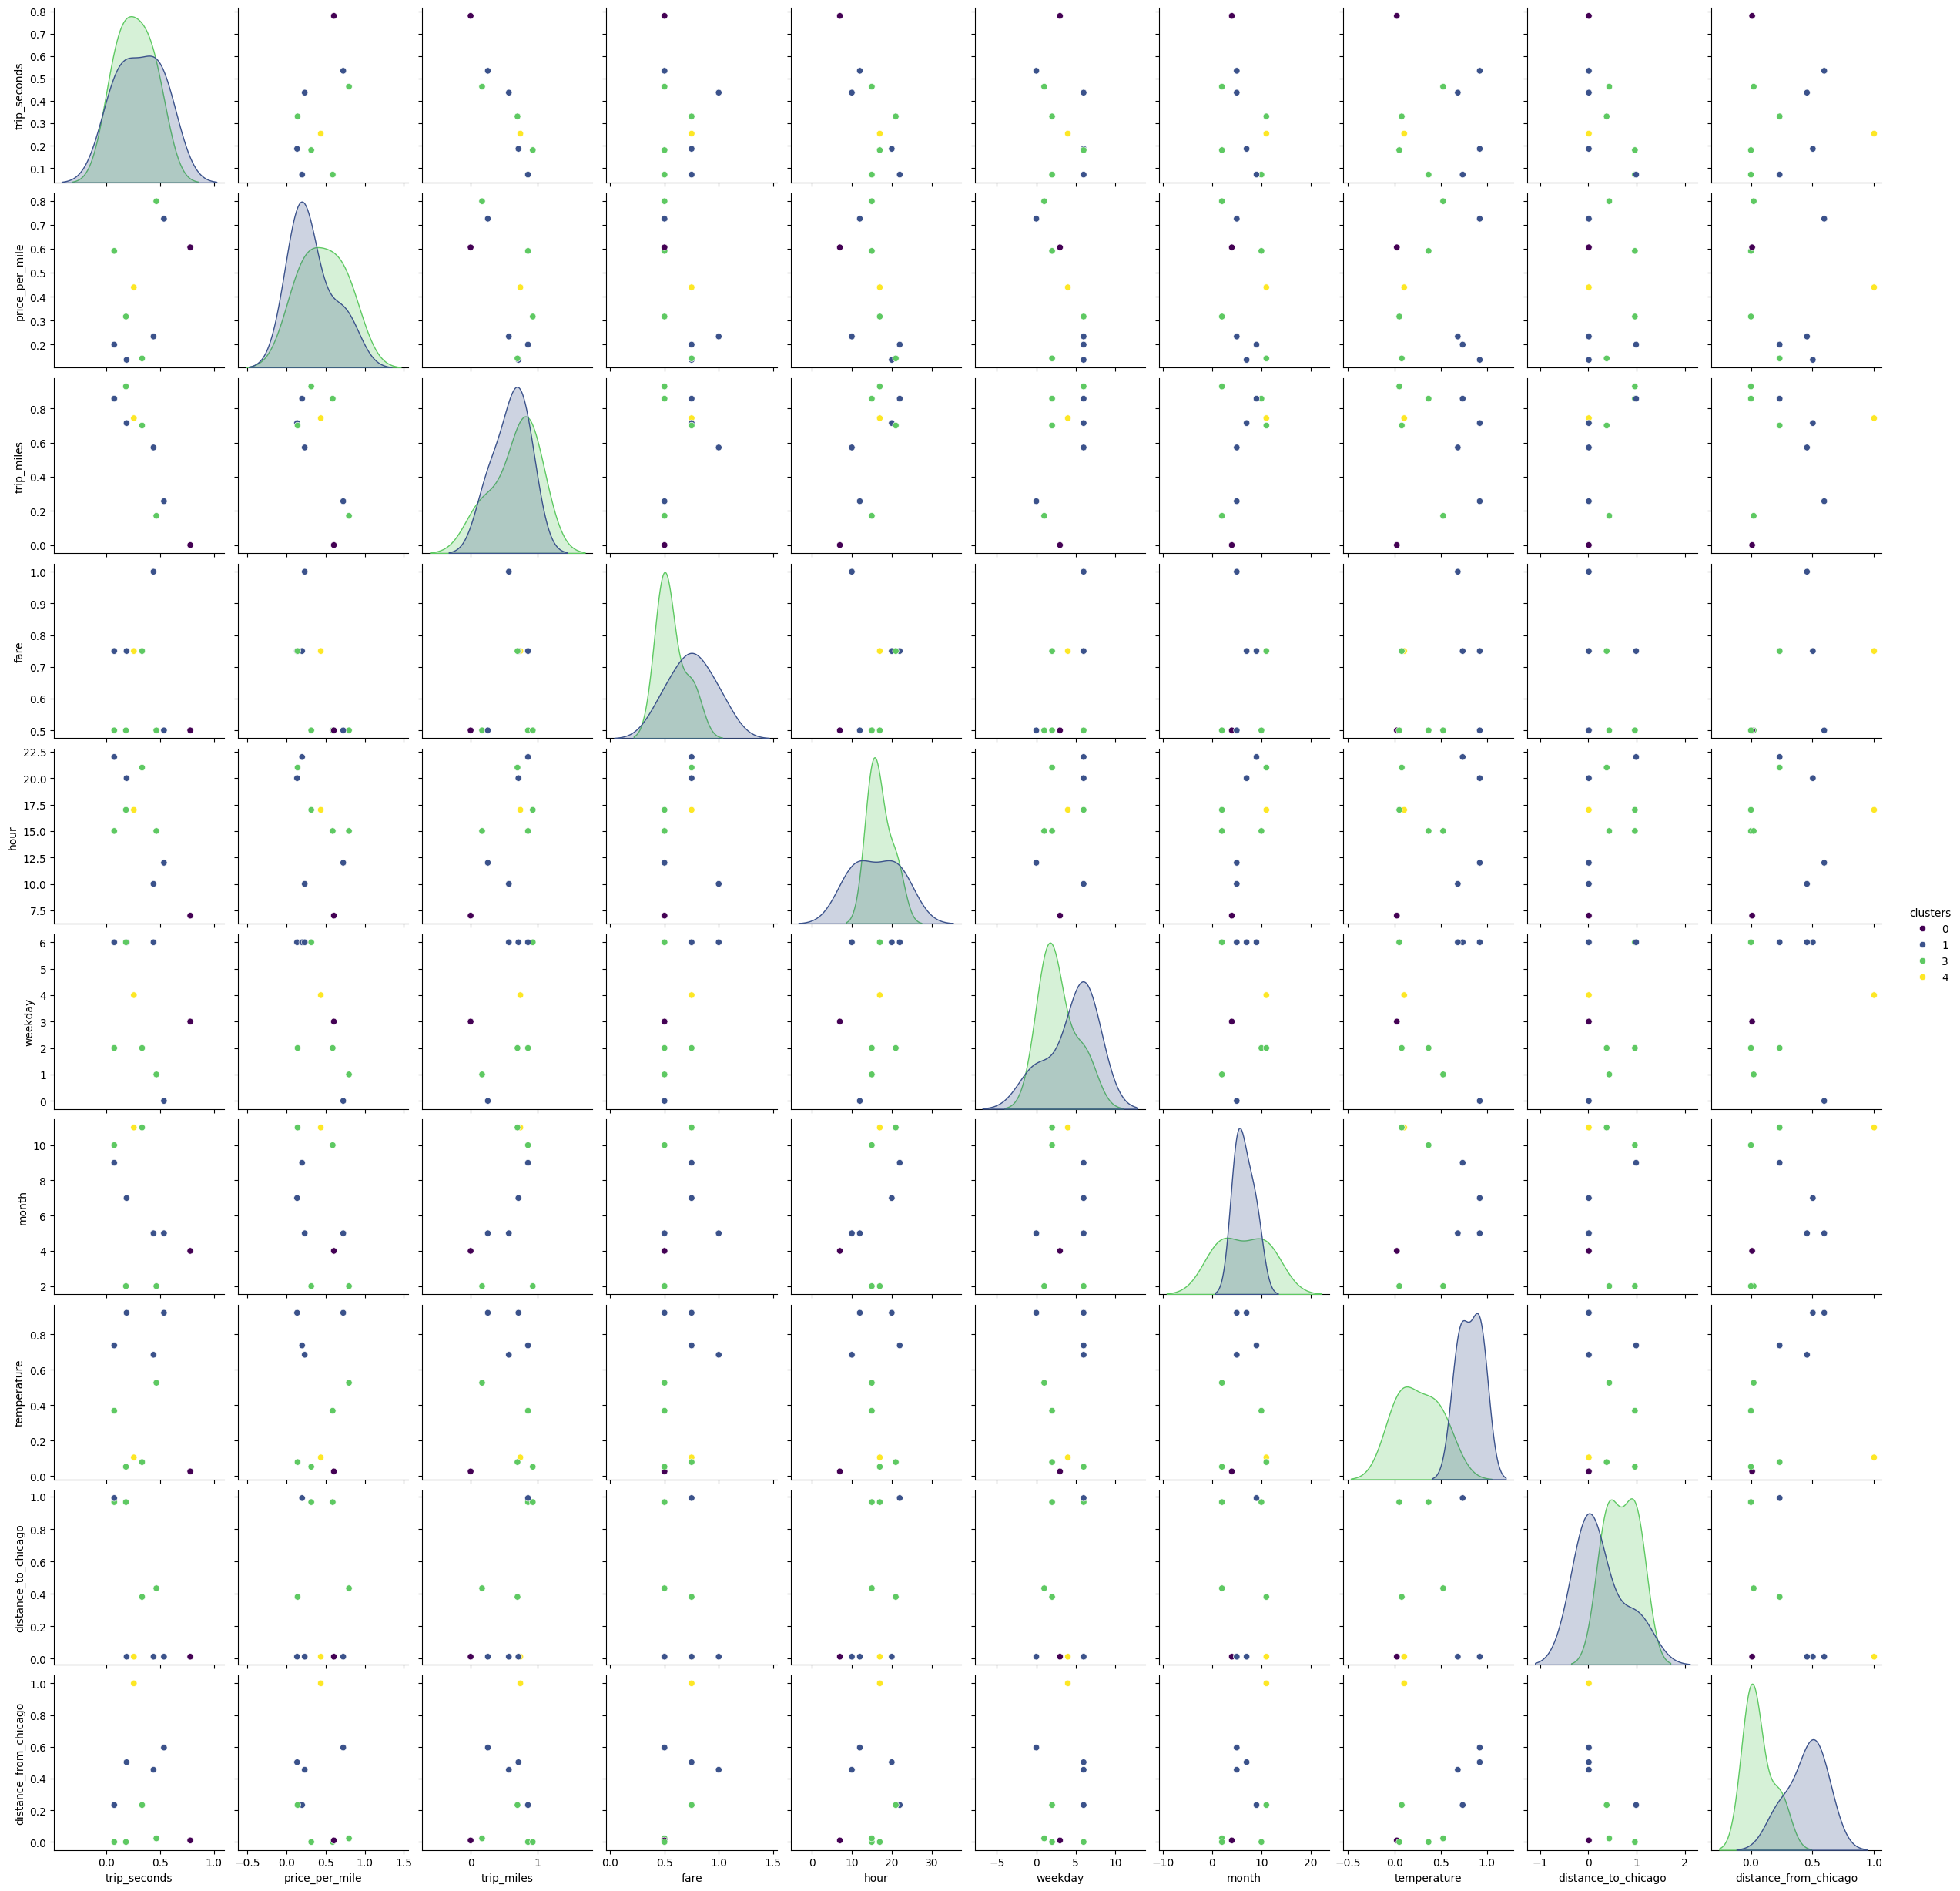

In [31]:
plt.figure(figsize=(16,9))
numerical_columns = Cluster_all_knn.columns[Cluster_all_knn.columns != "clusters"]
pairplot = sns.pairplot(Cluster_all_knn.sample(n=10, random_state=42), hue="clusters", vars=numerical_columns, palette="viridis")

pairplot.savefig("pairplot_knn.png")

plt.show()

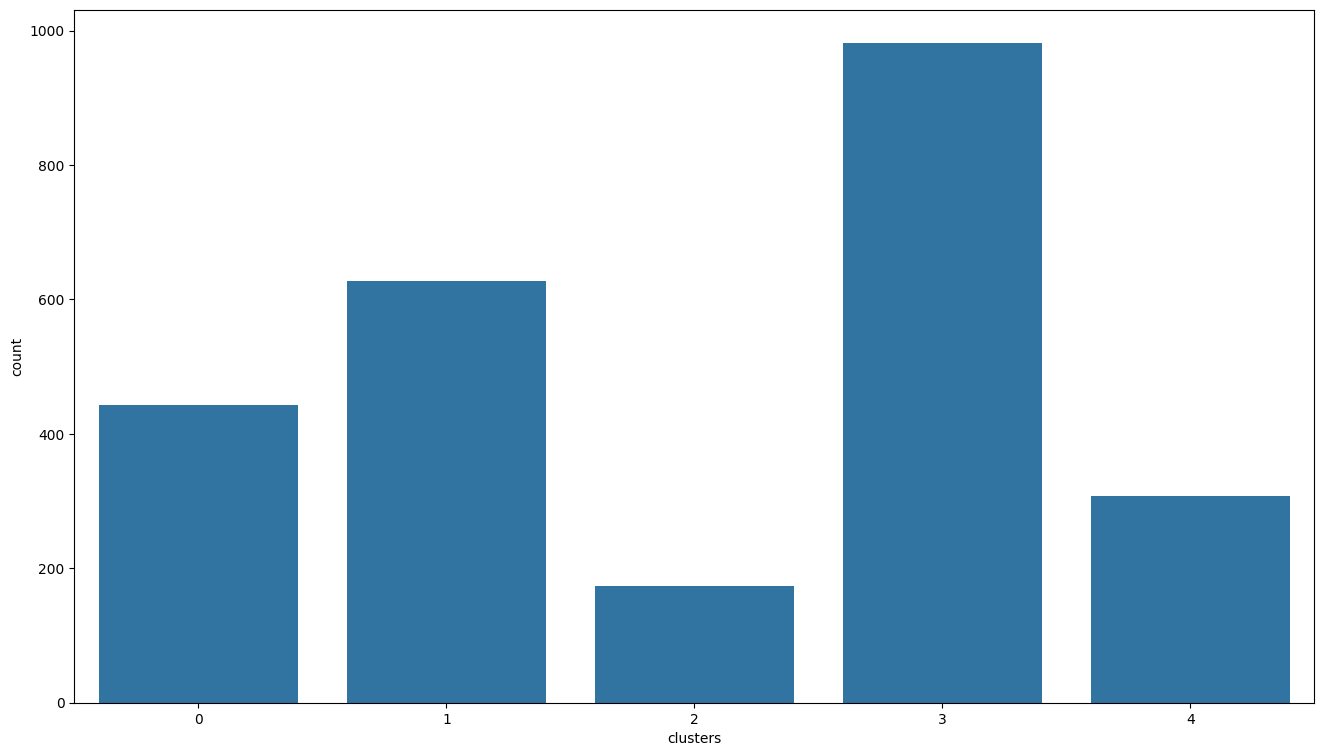

In [32]:
plt.figure(figsize=(16,9))
sns.countplot(data=Cluster_all_knn, x="clusters")
plt.show()

## Clustering (Soft)

In [33]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=5).fit(X_pca)
labels = gmm.predict(X_pca)

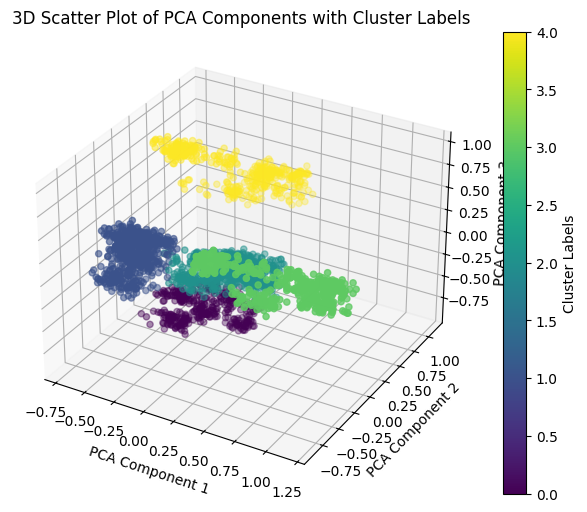

In [34]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color-coded clusters
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels, cmap='viridis')

# Add labels and title
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title('3D Scatter Plot of PCA Components with Cluster Labels')

# Add colorbar for cluster labels
colorbar = plt.colorbar(scatter)
colorbar.set_label('Cluster Labels')

# Display the plot
plt.show()

In [35]:
probs = gmm.predict_proba(X_pca)
print(probs[:5].round(3))
#print(X_pca)

[[0.039 0.    0.961 0.    0.   ]
 [0.252 0.    0.748 0.    0.   ]
 [0.035 0.    0.965 0.    0.   ]
 [0.229 0.    0.771 0.    0.   ]
 [0.016 0.    0.984 0.    0.   ]]


In [36]:
Cluster_all_gmm = Cluster_all.copy()
Cluster_all_gmm["clusters"]= labels

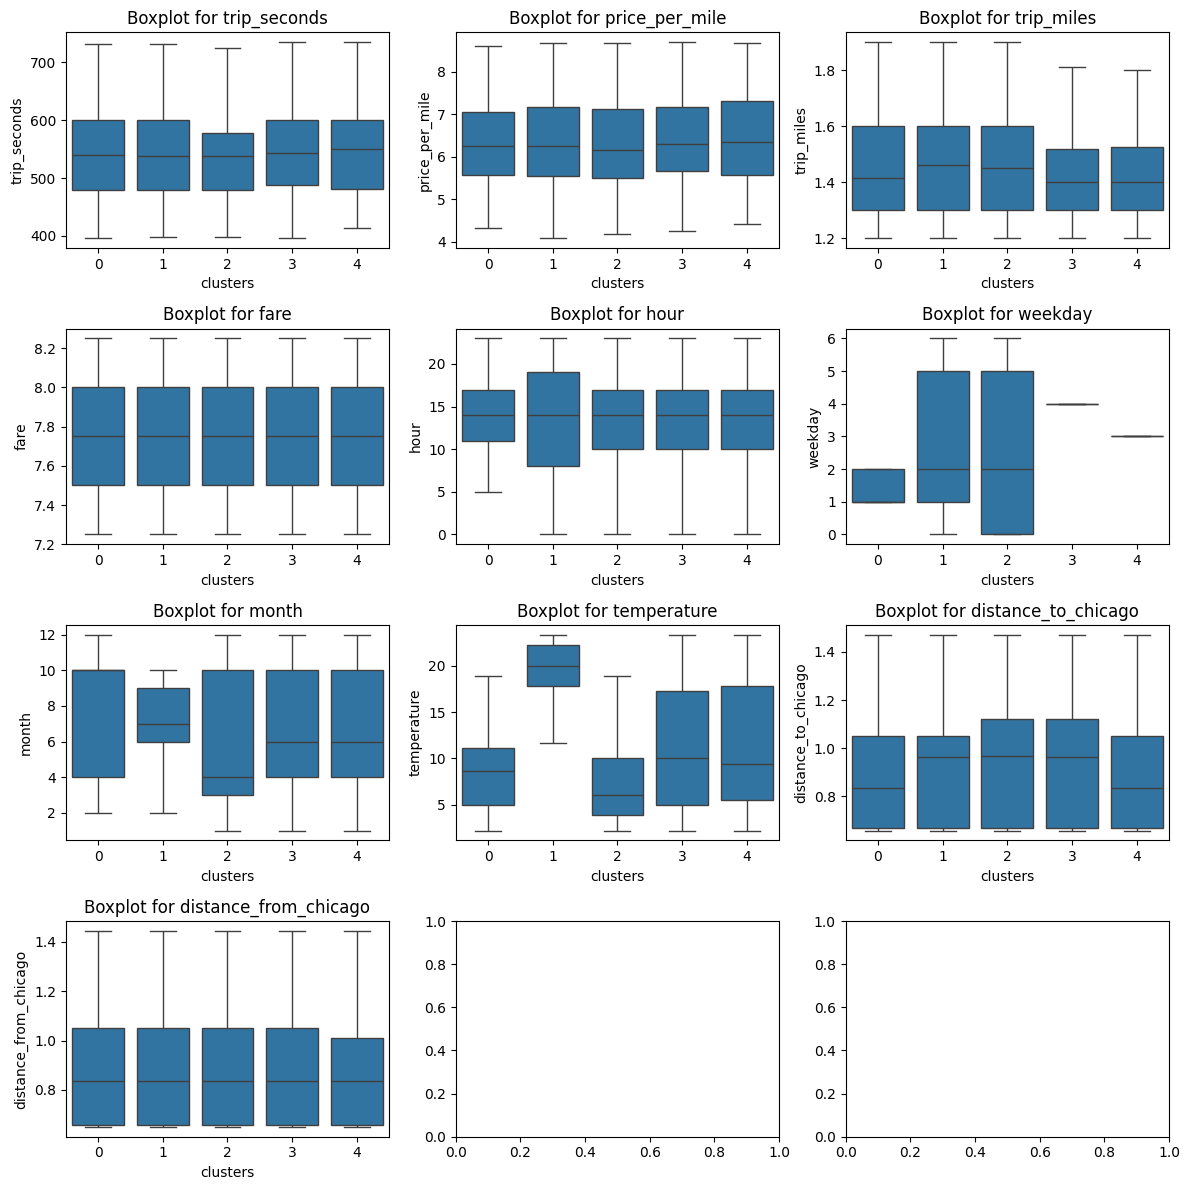

In [37]:
features = ["trip_seconds", "price_per_mile", "trip_miles", "fare", "hour", "weekday", "month","temperature", "distance_to_chicago", "distance_from_chicago"]

# Create a 3x3 subplot grid
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 12))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate through features and create boxplots
for i, feature in enumerate(features):
    
    sns.boxplot(x='clusters', y=feature, data=Cluster_all_gmm, ax=axes[i], showfliers=False)
    
    # Set subplot title
    axes[i].set_title(f'Boxplot for {feature}')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

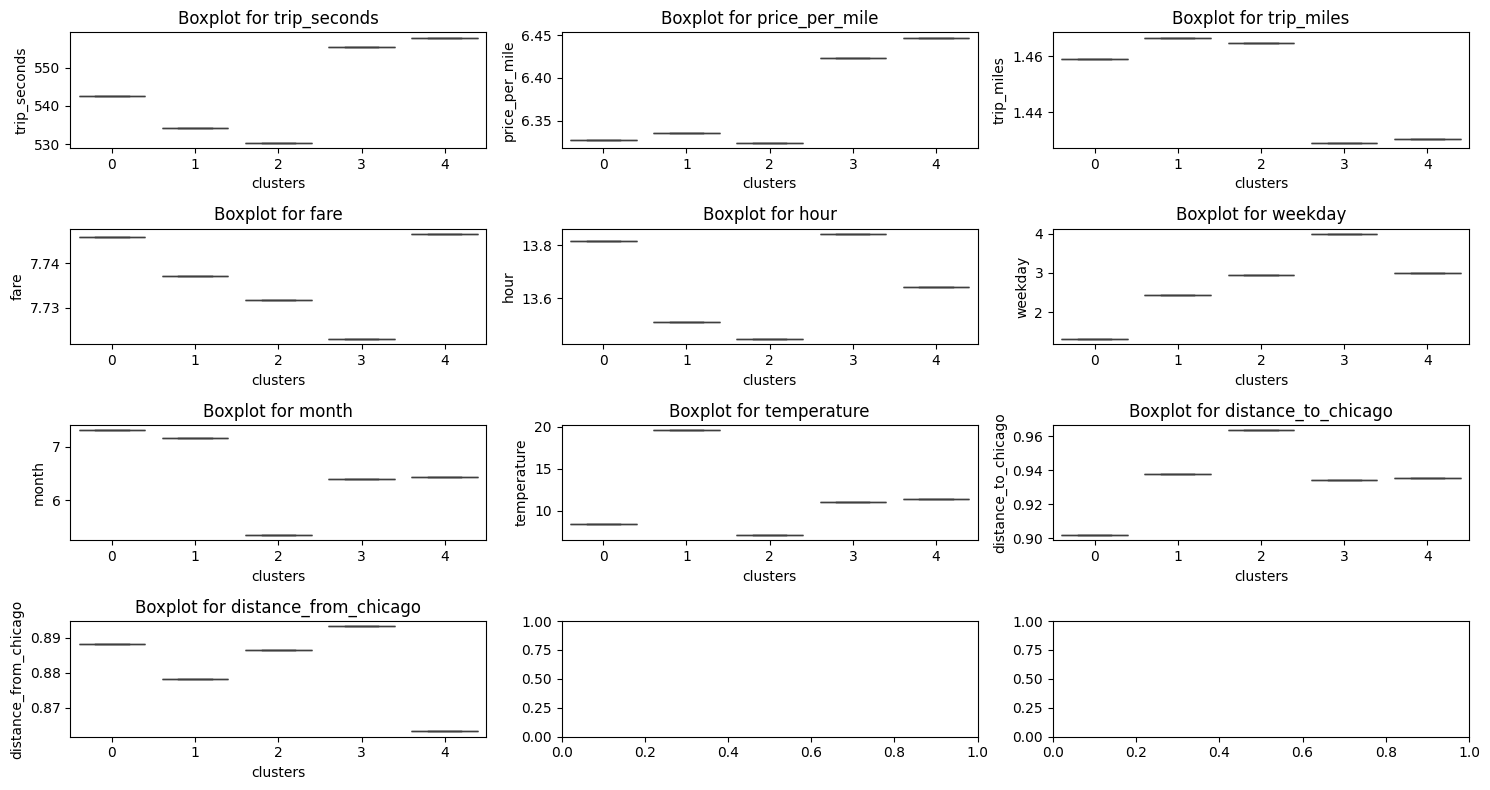

In [38]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate through features and create boxplots
for i, feature in enumerate(features):
    df = Cluster_all_gmm[[feature, 'clusters']].groupby('clusters', as_index=False).mean()
    
    # Plot boxplot in the i-th subplot
    sns.boxplot(x='clusters', y=df.columns[1], data=df, ax=axes[i])
    
    # Set subplot title
    axes[i].set_title(f'Boxplot for {df.columns[1]}')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

In [39]:
Cluster_all_gmm[columns_to_normalize] = scaler.fit_transform(Cluster_all_gmm[columns_to_normalize])

<Figure size 1600x900 with 0 Axes>

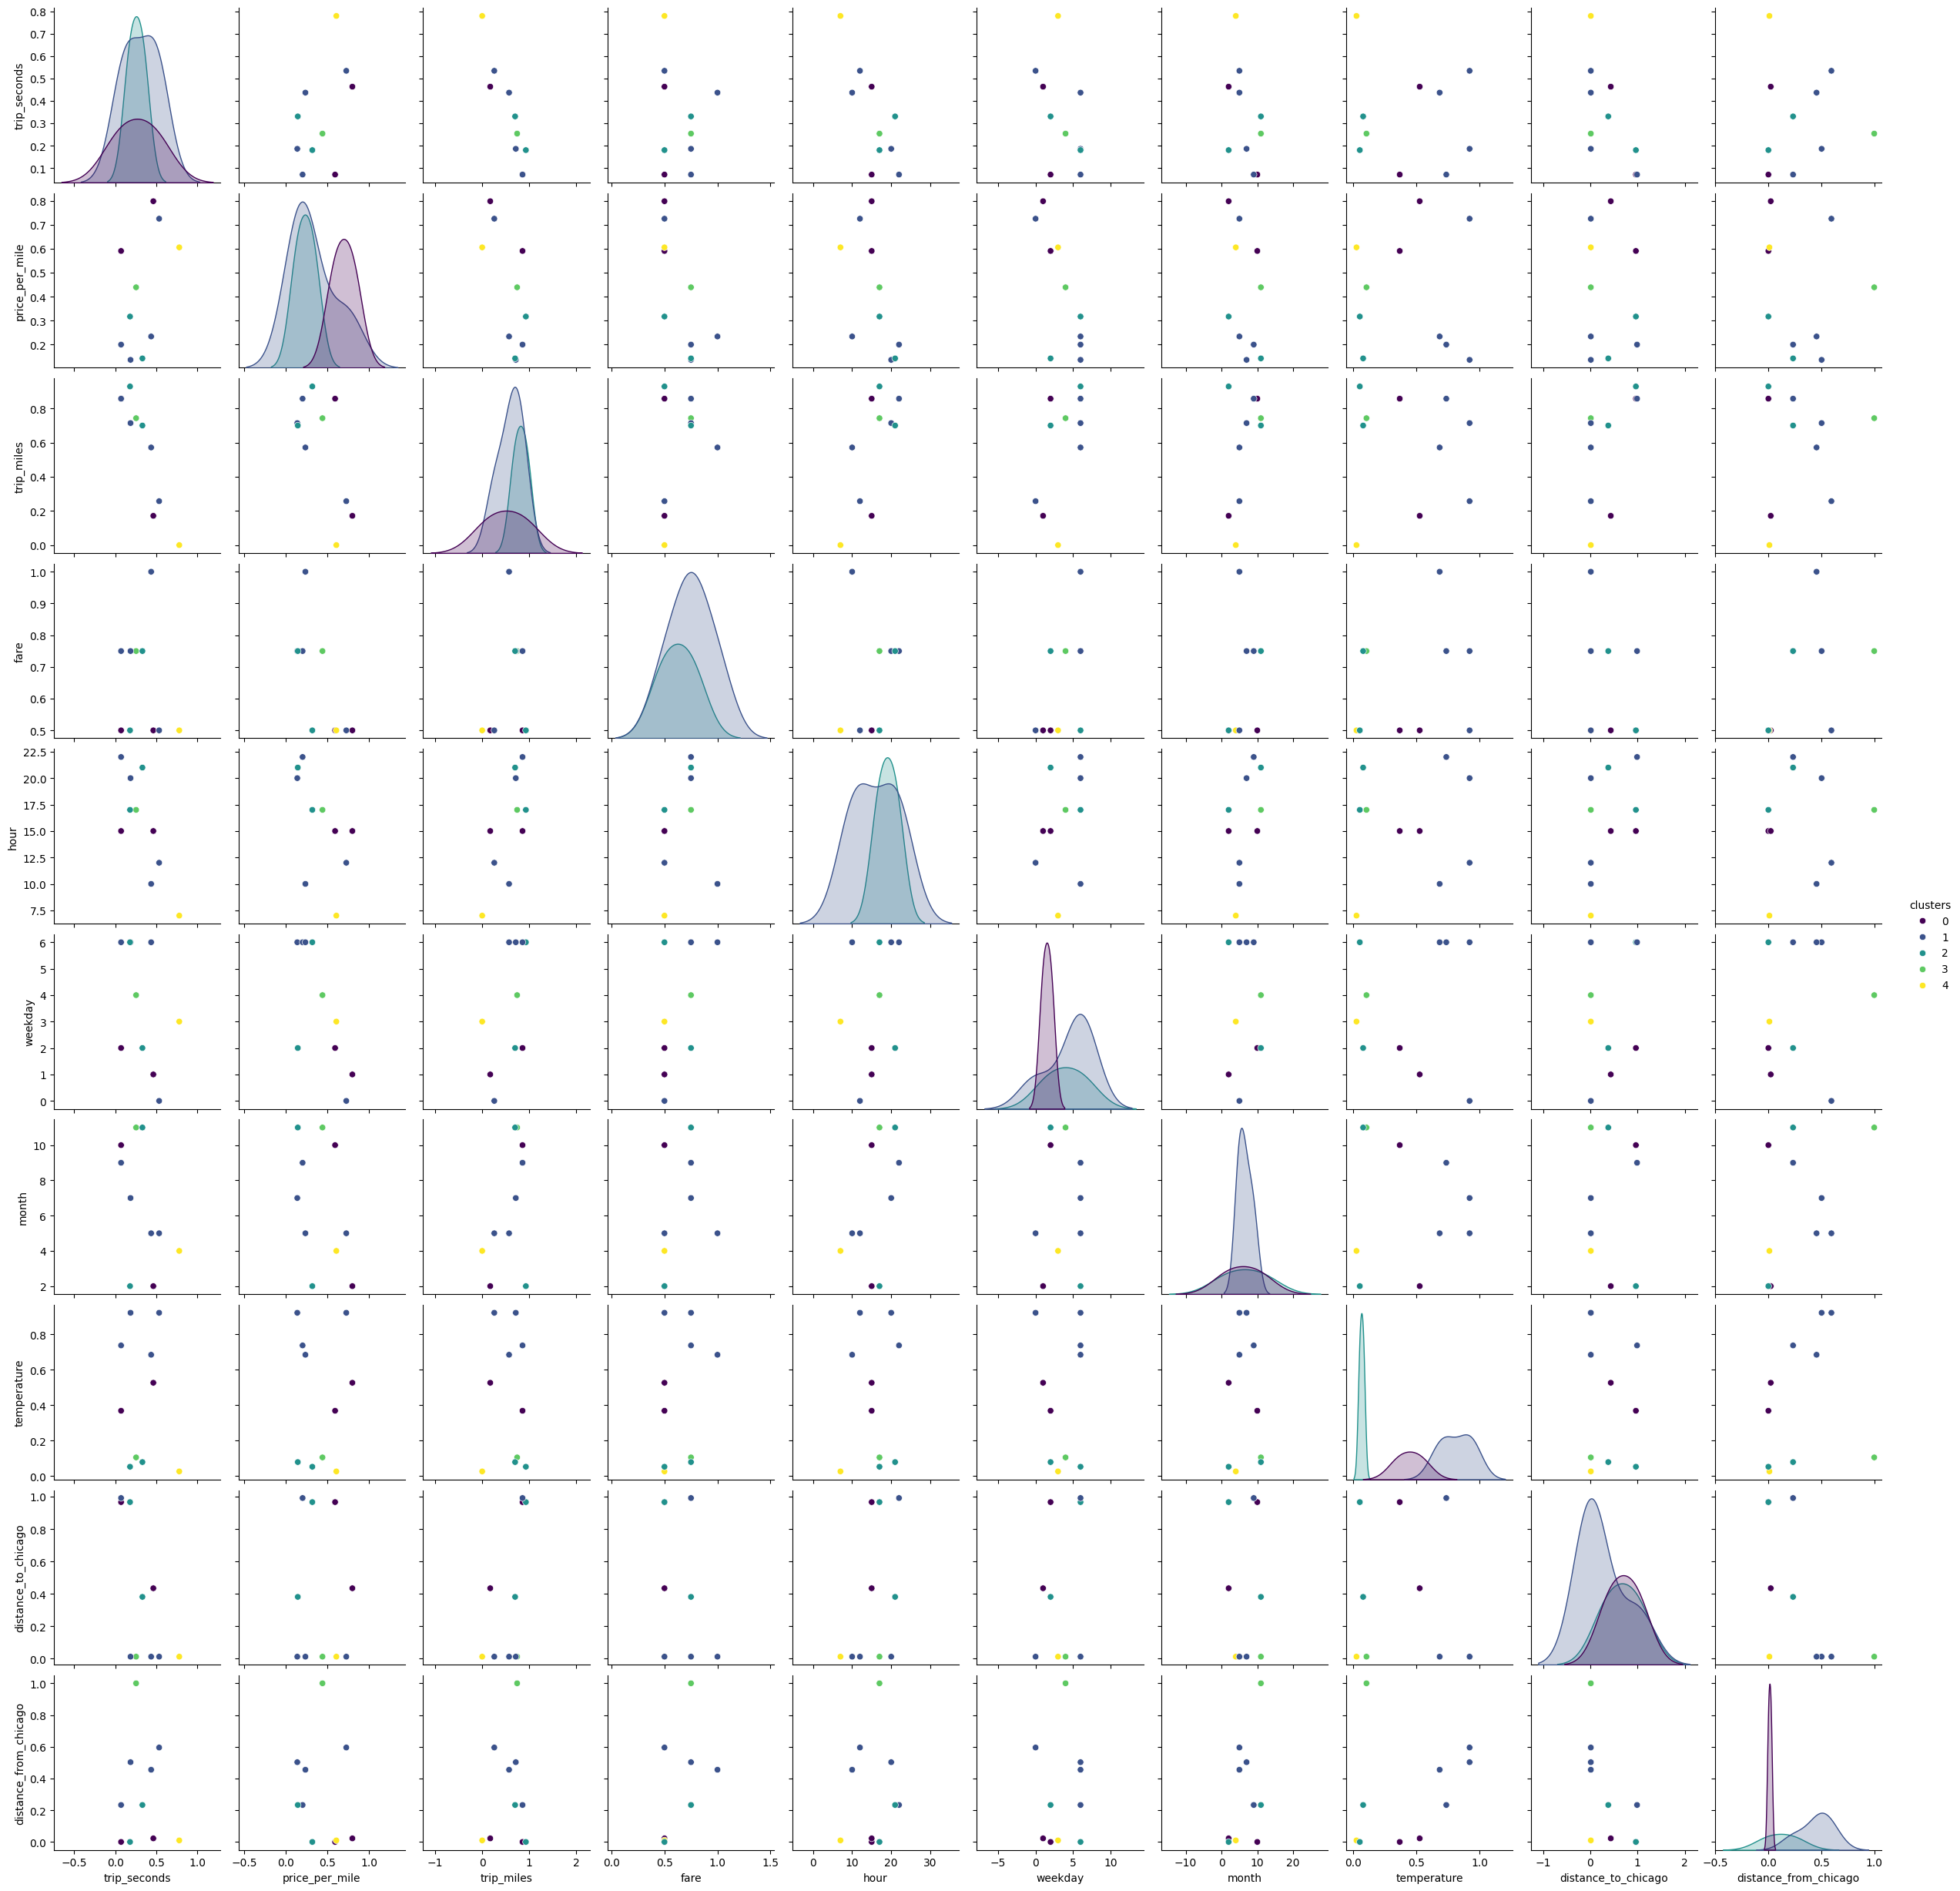

In [40]:
plt.figure(figsize=(16,9))
numerical_columns = Cluster_all_gmm.columns[Cluster_all_gmm.columns != "clusters"]
pairplot = sns.pairplot(Cluster_all_gmm.sample(n=10, random_state=42), hue="clusters", vars=numerical_columns, palette="viridis")

pairplot.savefig("pairplot_gmm.png")

plt.show()

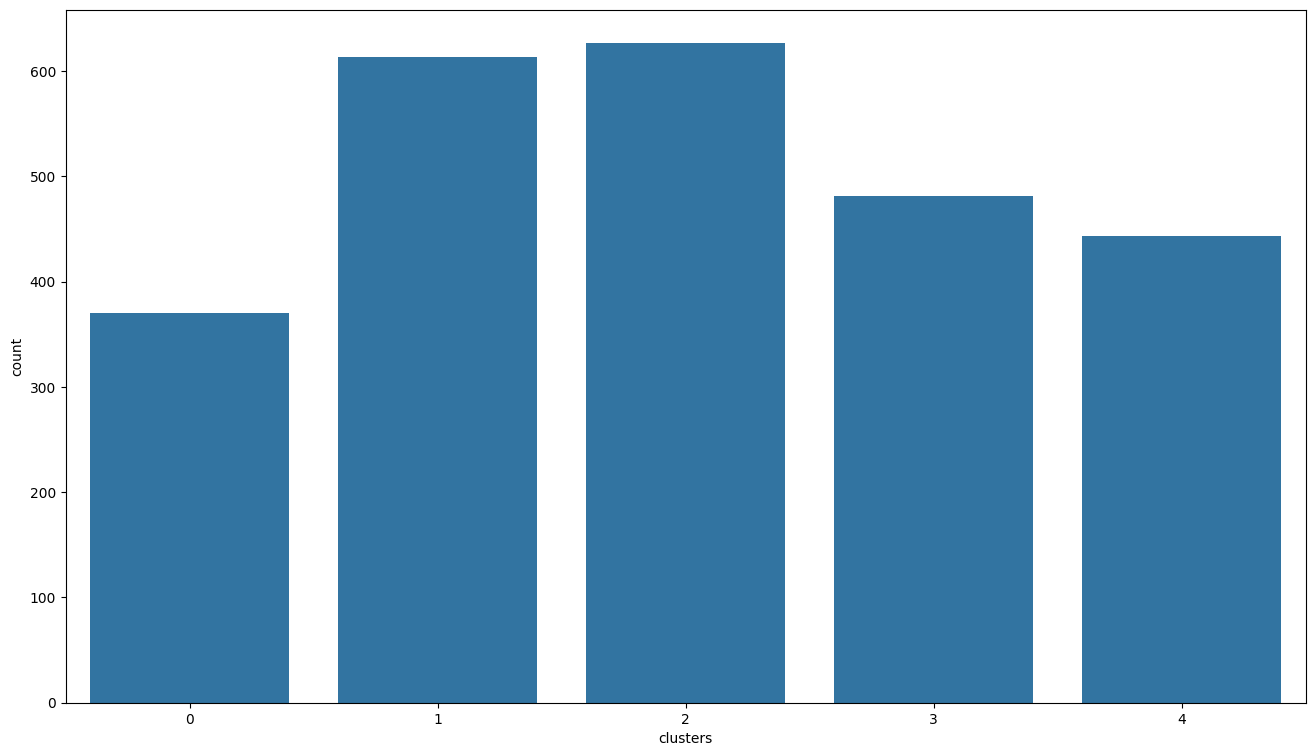

In [41]:
plt.figure(figsize=(16,9))
sns.countplot(data=Cluster_all_gmm, x="clusters")
plt.show()

## Spatial Kernel Density Estimation

## Comparison